In [1]:
using CSV
using DataFrames
using Plots
using FFTW

In [2]:
# MODEL, VISUALIZATION AND MANAGING FUNCTIONS FILES

push!(LOAD_PATH, "./src")
include("../src/DirUtils.jl")
include("../src/SDDESolarDynamo.jl")
include("../src/VisualizationTools.jl")

using .DirUtils
using .SDDESolarDynamo
using .VisualizationTools

In [3]:
# Load data
data = load_sunspots_data()

first(data, 5)

Row,year,open_magn_flux,open_magn_flux_err,ssa_open_magn_flux,sunspots_num,sunspots_err,ssa_sunspots
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,971,7.86,1.65,5.29,120.5,39.4,62.2
2,972,4.94,1.06,5.36,47.9,17.4,65.3
3,973,3.08,1.24,5.45,2.7,20.2,68.6
4,974,1.9,1.39,5.56,-25.5,24.4,71.2
5,975,1.26,1.44,5.65,-49.7,23.3,73.0


In [4]:
# CHOICE OF THE DIRECTORY TO LOAD AND PLOT

# Current directory
initial_dir = pwd()

# Going into "synthetic_data_sim/synthetic$x" or "real_data_sim/real$x"
x = 2
switch_dir("real", x)
current_dir = pwd()

# NB: don't run this cell again! First go back to the initial directory!
# if pwd() != initial_dir
#     cd("./../../examples")
# end

Moved to: /mnt/c/Users/Utente/SDDESolarDynamo.jl/examples/real_data_sim/real2


"/mnt/c/Users/Utente/SDDESolarDynamo.jl/examples/real_data_sim/real2"

In [5]:
df_rho = CSV.read("rho.csv", DataFrame)
df_pop = CSV.read("pop.csv", DataFrame)

best_indices, best_particles = select_best_particles(df_rho, df_pop, k=10)
println("Best indices:", best_indices, "\n")
println("Best particles\n:", best_particles)

Best indices:[341, 28, 7, 19, 197, 731, 597, 839, 848, 966]

Best particles
:10×5 DataFrame
 Row │ N_value   T_value   tau_value  sigma_value  Bmax_value 
     │ Float64   Float64   Float64    Float64      Float64    
─────┼────────────────────────────────────────────────────────
   1 │ 14.237    1.93652     3.46033    0.116459      6.77625
   2 │  7.84495  2.95556     5.93903    0.14472       6.24803
   3 │ 10.3164   1.18796     4.17075    0.291615      8.32003
   4 │  5.81553  2.60326     4.80013    0.264181      6.96022
   5 │  5.56769  0.191693    2.63214    0.168907      6.55861
   6 │  8.43159  2.91508     3.26384    0.0386633    10.7283
   7 │  5.4689   9.22687     2.30571    0.223193      2.78933
   8 │ 12.285    0.757274    3.2452     0.130041     11.8585
   9 │  9.21515  2.30822     3.13999    0.221191      9.39745
  10 │  7.62292  4.37879     3.25956    0.0340891     3.74373


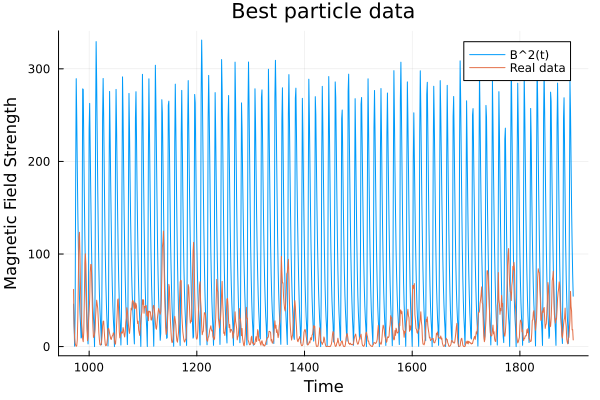

In [6]:
#par = [N, T, tau, sigma, B_max]
par = best_particles[1, :]

# Time
Tsim = [971, 1899]
dt = 0.1

# DATA SIMULATION

# Data simulation with the chosen parameter
sol = bfield(par, Tsim, dt)

# Important solution data that are necessary afterwards
t = sol.t
u = sol[1, :]
du = sol[2, :]

# Plot simulated data vs real data
Plots.plot(t, u.^2, label = "B^2(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", 
               title = "Best particle data", linewidth = 1)

Plots.plot!(data.year, data.open_magn_flux.^2, label = "Real data")

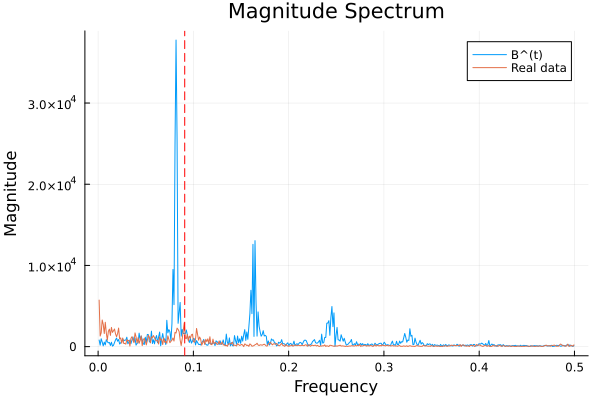

In [7]:
u = u.^2

Fs = 1 / (t[2] - t[1])
N = length(u)
freqs = fftfreq(N, Fs)

fourier_transform_sim = abs.(fft(u))

frequencies = freqs[(freqs .> 0) .& (freqs .<= 0.5)]
amplitudes = abs.(fourier_transform_sim[(freqs .> 0) .& (freqs .<= 0.5)])

Plots.plot(frequencies, amplitudes, xlabel="Frequency", ylabel="Magnitude", title="Magnitude Spectrum", label = "B^(t)")

t = data.year
u = data.open_magn_flux.^2

Fs = 1 / (t[2] - t[1])
N = length(u)
freqs = fftfreq(N, Fs)

fourier_transform_sim = abs.(fft(u))

frequencies = freqs[(freqs .> 0) .& (freqs .<= 0.5)]
amplitudes = abs.(fourier_transform_sim[(freqs .> 0) .& (freqs .<= 0.5)])
Plots.plot!(frequencies, amplitudes, label = "Real data")
vline!([1/11], line=:dash, color=:red, label=false)

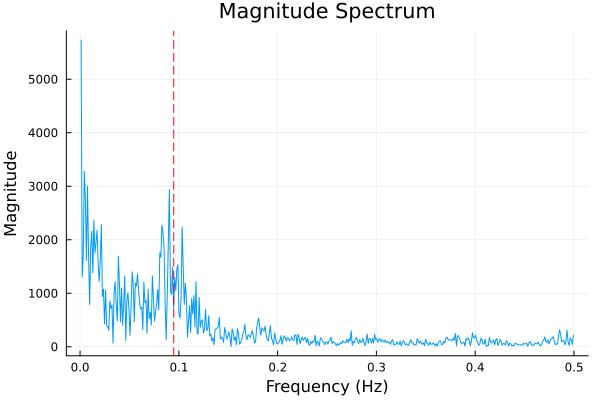

In [8]:
indices = [45]
plot_fourier_spectrum(t, u, indices; save=false)

Selected parameters (mode): [13.312585987429111, 2.111670685961634, 0.4370882928707919, 0.19313380511408235, 2.97718129369982]


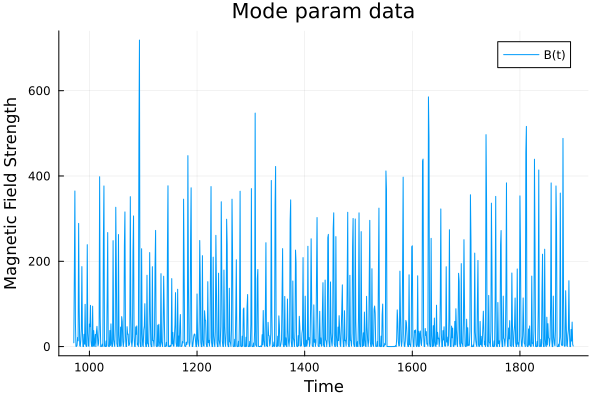

In [9]:
par, title_str = postprocessing_params(df_pop; strategy = :mode)

# Time
Tsim = [971, 1899]
dt = 0.1

# Simulate
sol = bfield(par, Tsim, dt)

# Extract solution
t = sol.t
u = sol[1, :]
du = sol[2, :]

# Plot
Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength",
           title = title_str, linewidth = 1)

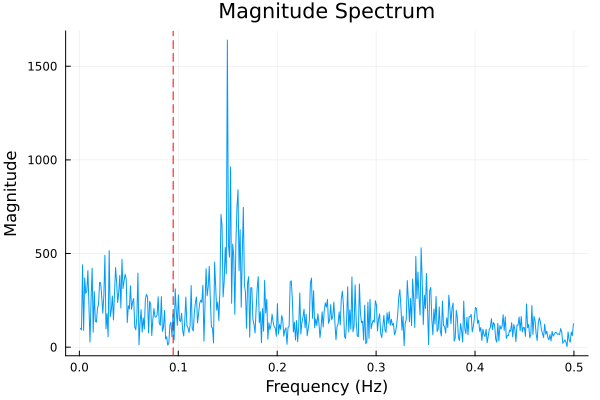

In [10]:
indices = [45]
plot_fourier_spectrum(t, u, indices; save=false)

Selected parameters (mean): [9.716080681831153, 3.964739715424432, 3.2251824889361154, 0.15259301425692245, 6.332108209322024]


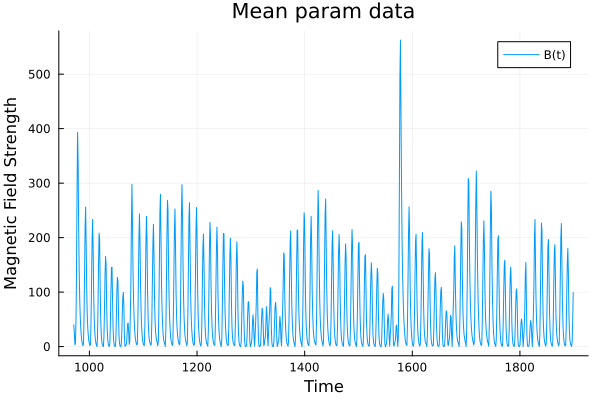

In [11]:
par, title_str = postprocessing_params(df_pop; strategy = :mean)

# Time
Tsim = [971, 1899]
dt = 0.1

# Simulate
sol = bfield(par, Tsim, dt)

# Extract solution
t = sol.t
u = sol[1, :]
du = sol[2, :]

# Plot
Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength",
           title = title_str, linewidth = 1)

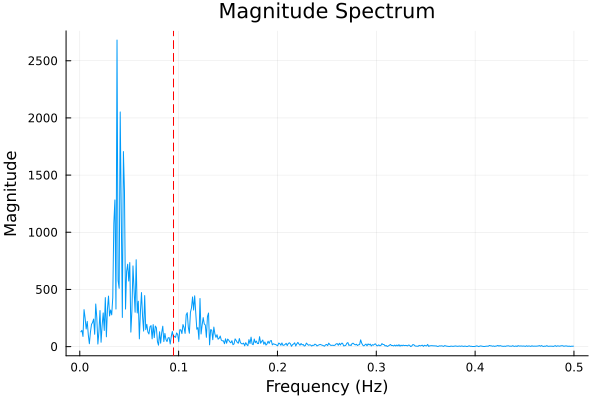

In [12]:
indices = [45]
plot_fourier_spectrum(t, u, indices; save=false)

Selected parameters (hybrid): [9.716080681831153, 2.1513112250958524, 0.4370882928707919, 0.19313380511408235, 2.97718129369982]


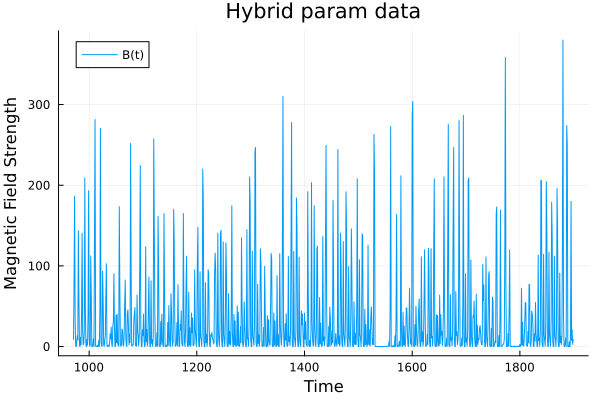

In [13]:
par, title_str = postprocessing_params(df_pop; strategy = :hybrid)

# Time
Tsim = [971, 1899]
dt = 0.1

# Simulate
sol = bfield(par, Tsim, dt)

# Extract solution
t = sol.t
u = sol[1, :]
du = sol[2, :]

# Plot
Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength",
           title = title_str, linewidth = 1)

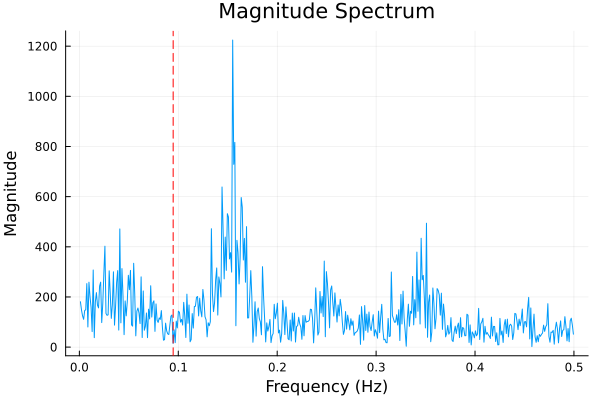

In [14]:
indices = [45]
plot_fourier_spectrum(t, u, indices; save=false)

In [15]:
# DIRECTORY MANAGING

# Go back to the initial directory if not already there
if pwd() != initial_dir
    cd("./../../../examples")
end

pwd()

"/mnt/c/Users/Utente/SDDESolarDynamo.jl/examples"